## ML Project
## Simple models

### Importing libraries

In [1]:
from sys import stdout
import numpy as np
import pandas as pd
import json

# Reading data from external sources
import urllib as u
from urllib.request import urlopen

# Machine learning (preprocessing, models, evaluation)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Graphics
from tqdm import tqdm
import seaborn as sns
import os
import matplotlib.pyplot as plt
from numpy import loadtxt
from xgboost import plot_importance
from matplotlib import pyplot

# ******************************* All Data ********************************

### 1. Importing dataset

In [2]:
data=pd.read_csv("project.csv", sep=";")
data.head()

,id,lat,lng,mount,fabr,house,POI,PM25,min,max,median,T1,T2,T3,Tnear,traffic,avto
0,1,43.313,76.939,11.15,6.50,0,60,66.921183,6.989510,339.932961,45.426184,4.7,20.7,17.2,4.7,1,4
1,2,43.224,76.938,4.09,9.80,0,40,46.882251,5.112117,850.854659,31.369472,9.8,24.0,34.7,9.8,2,10
2,3,43.240,76.874,8.86,11.00,0,80,48.741605,4.452778,303.609451,30.765588,9.1,14.6,28.0,9.1,2,0
3,4,43.265,76.973,4.76,5.23,1,100,48.070677,5.491803,283.174840,30.792479,6.6,24.6,24.3,6.6,1,0
4,5,43.253,76.910,9.04,4.12,0,100,45.223812,3.830000,387.072967,25.215714,5.6,16.5,25.3,5.6,3,7


In [3]:
#Leaving only important data
data=data[["lat", "lng", "mount", "fabr", "house", "POI", "T1", "T2", "T3", "Tnear", "traffic", "avto", "PM25"]]

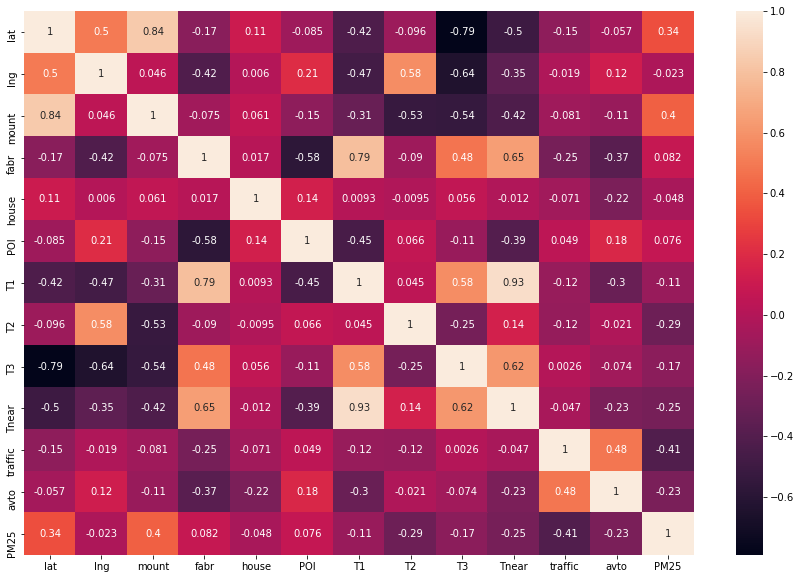

In [4]:
cols=data.columns
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15,10))
data_cor= sns.heatmap(data[cols].corr(),
                 cbar=True,
                 annot=True)
file_name='cor_matrix.jpg'
plt.savefig(file_name,format='jpg',dpi=600)

### 2. Data preporation

In [5]:
#Adding new feature - PM2.5 of the another sensor with the most similar characteristics
cols=data.columns
data_corrT=data.T.corr()
data_corrT[data_corrT==1.0] = 0
data_corrT["max"]=data_corrT.idxmax()
data_corrT.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,max
0,0.000000,0.933034,0.949023,0.916318,0.907442,0.927524,0.779976,0.960858,0.698743,0.992467,...,0.642665,0.817994,0.556213,0.684356,0.611198,0.650416,0.877886,0.701050,0.857838,9
1,0.933034,0.000000,0.902155,0.844382,0.834612,0.991798,0.814499,0.946724,0.876184,0.947510,...,0.785096,0.823965,0.788234,0.832797,0.810507,0.835598,0.874437,0.853083,0.891457,5
2,0.949023,0.902155,0.000000,0.982986,0.981761,0.916446,0.614842,0.976120,0.616582,0.947637,...,0.554724,0.931007,0.530705,0.596256,0.546900,0.572930,0.963948,0.616969,0.936535,24
3,0.916318,0.844382,0.982986,0.000000,0.994005,0.858214,0.490528,0.923829,0.516683,0.917488,...,0.466933,0.944274,0.418765,0.498193,0.448004,0.484003,0.972565,0.502650,0.919018,30
4,0.907442,0.834612,0.981761,0.994005,0.000000,0.850086,0.480983,0.930279,0.496461,0.900810,...,0.443498,0.949275,0.402116,0.494680,0.419959,0.461421,0.974349,0.496253,0.923760,12


In [6]:
data["PM25near"]=0
for i in range(len(data)):
    data.iloc[i,-1]=data.iloc[data_corrT.iloc[i,-1],12]
data.head()

,lat,lng,mount,fabr,house,POI,T1,T2,T3,Tnear,traffic,avto,PM25,PM25near
0,43.313,76.939,11.15,6.50,0,60,4.7,20.7,17.2,4.7,1,4,66.921183,68.388934
1,43.224,76.938,4.09,9.80,0,40,9.8,24.0,34.7,9.8,2,10,46.882251,38.903543
2,43.240,76.874,8.86,11.00,0,80,9.1,14.6,28.0,9.1,2,0,48.741605,42.793549
3,43.265,76.973,4.76,5.23,1,100,6.6,24.6,24.3,6.6,1,0,48.070677,39.117934
4,43.253,76.910,9.04,4.12,0,100,5.6,16.5,25.3,5.6,3,7,45.223812,46.175405


In [7]:
#Adding new column CLASS
data["Class"]=0

for i in range(len(data)):
    if data.iloc[i,12]<26:
        data.iloc[i,14]=1
    elif (data.iloc[i,12]>26)&(data.iloc[i,12]<40):
        data.iloc[i,14]=2
    else:
        data.iloc[i,14]=3
data.Class.value_counts()

3    19
2    11
1    10
Name: Class, dtype: int64

### 3. Models training

In [8]:
data_model=data[["lat", "lng", "mount", "fabr", "house", "POI", "Tnear", "traffic", "avto", "Class"]]
data_model.head()

,lat,lng,mount,fabr,house,POI,Tnear,traffic,avto,Class
0,43.313,76.939,11.15,6.50,0,60,4.7,1,4,3
1,43.224,76.938,4.09,9.80,0,40,9.8,2,10,3
2,43.240,76.874,8.86,11.00,0,80,9.1,2,0,3
3,43.265,76.973,4.76,5.23,1,100,6.6,1,0,3
4,43.253,76.910,9.04,4.12,0,100,5.6,3,7,3


In [9]:
# Divide data in train and testing
train_split, test_split = train_test_split(data_model, test_size=0.4, random_state=1, stratify=data['Class'])
X_train = train_split.iloc[:, :-1].values
y_train = train_split.iloc[:, -1].values
X_test = test_split.iloc[:, :-1].values
y_test = test_split.iloc[:, -1].values

# Standardize train/test datasets (use same coeff.)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [10]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]

clf1 = GridSearchCV(SVC(random_state=1),
                    tuned_parameters,
                    n_jobs=6,
                    scoring='accuracy',
                    cv=5)
clf1.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf1.best_score_, clf1.best_params_))
print()

Best score, and parameters, found on development set:

0.580 for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}



In [11]:
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [8, 32, 64, 128],
                    'max_features': ['auto', 'sqrt'],
                    'max_depth': [4, 5, 6, 7, 8],
                    'criterion': ['gini', 'entropy']}

clf2 = GridSearchCV(RandomForestClassifier(random_state=1),
                    tuned_parameters,
                    n_jobs=6,
                    scoring='accuracy',
                    cv=5)
clf2.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf2.best_score_, clf2.best_params_))
print()

Best score, and parameters, found on development set:

0.630 for {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 64}



In [12]:
# Set the parameters by cross-validation
tuned_parameters = {'learning_rate': [0.01, 0.001],
              'max_depth': [4, 5, 6, 7, 8],
              'n_estimators': [32, 256, 512, 1024]}

clf3 = GridSearchCV(xgb.XGBClassifier(random_state=1),
                   tuned_parameters,
                   n_jobs=6,
                   scoring='accuracy', 
                   cv=5)
clf3.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf3.best_score_, clf3.best_params_))
print()

Best score, and parameters, found on development set:

0.540 for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 32}



In [13]:
# Set the parameters by cross-validation
tuned_parameters = {'hidden_layer_sizes': [(32,), (64,), (32, 64, 32)],
                    'activation': ['tanh', 'relu'],
                    'solver': ['lbfgs', 'adam', 'sgd']}

clf4 = GridSearchCV(MLPClassifier(random_state=1, batch_size=4, early_stopping=True), 
                    tuned_parameters,
                    n_jobs=6,
                    scoring='accuracy',
                    cv=5)

clf4.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf4.best_score_, clf4.best_params_))
print()

Best score, and parameters, found on development set:

0.540 for {'activation': 'relu', 'hidden_layer_sizes': (32,), 'solver': 'lbfgs'}



### 4. Models testing

In [14]:
print()
print(53 * '=')
print(15 * ' ' + 'SUPPORT VECTOR MACHINE')
print(53 * '-')
print(classification_report(y_test, clf1.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')
print(53 * '=')
print(20 * ' ' + 'RANDOM FOREST')
print(53 * '-')
print(classification_report(y_test, clf2.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')
print(53 * '=')
print(14 * ' ' + 'EXTREME GRADIENT BOOSTING')
print(53 * '-')
print(classification_report(y_test, clf3.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')
print(53 * '=')
print(15 * ' ' + 'MULTI-LAYER PERCEPTRON')
print(53 * '-')
print(classification_report(y_test, clf4.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')


               SUPPORT VECTOR MACHINE
-----------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      0.25      0.40         4
           2       0.43      0.75      0.55         4
           3       0.75      0.75      0.75         8

    accuracy                           0.62        16
   macro avg       0.73      0.58      0.57        16
weighted avg       0.73      0.62      0.61        16

-----------------------------------------------------
                    RANDOM FOREST
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.60      0.75      0.67         4
           3       0.64      0.88      0.74         8

    accuracy                           0.62        16
   macro avg       0.41      0.54      0.47        16
weighted avg       0.47      0.62      0.54        16

---

C:\Users\Eleonora\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ******With PM2.5near*********

### 1. Training

In [15]:
data_model=data[["lat", "lng", "mount", "fabr", "house", "POI", "Tnear", "traffic", "avto", "PM25near","Class"]]
data_model.head()

,lat,lng,mount,fabr,house,POI,Tnear,traffic,avto,PM25near,Class
0,43.313,76.939,11.15,6.50,0,60,4.7,1,4,68.388934,3
1,43.224,76.938,4.09,9.80,0,40,9.8,2,10,38.903543,3
2,43.240,76.874,8.86,11.00,0,80,9.1,2,0,42.793549,3
3,43.265,76.973,4.76,5.23,1,100,6.6,1,0,39.117934,3
4,43.253,76.910,9.04,4.12,0,100,5.6,3,7,46.175405,3


In [16]:
# Divide data in train and testing
train_split, test_split = train_test_split(data_model, test_size=0.4, random_state=1, stratify=data['Class'])
X_train = train_split.iloc[:, :-1].values
y_train = train_split.iloc[:, -1].values
X_test = test_split.iloc[:, :-1].values
y_test = test_split.iloc[:, -1].values

# Standardize train/test datasets (use same coeff.)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [17]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]

clf1 = GridSearchCV(SVC(random_state=1),
                    tuned_parameters,
                    n_jobs=6,
                    scoring='accuracy',
                    cv=5)
clf1.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf1.best_score_, clf1.best_params_))
print()

Best score, and parameters, found on development set:

0.630 for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}



In [18]:
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [8, 32, 64, 128],
                    'max_features': ['auto', 'sqrt'],
                    'max_depth': [4, 5, 6, 7, 8],
                    'criterion': ['gini', 'entropy']}

clf2 = GridSearchCV(RandomForestClassifier(random_state=1),
                    tuned_parameters,
                    n_jobs=6,
                    scoring='accuracy',
                    cv=5)
clf2.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf2.best_score_, clf2.best_params_))
print()

Best score, and parameters, found on development set:

0.630 for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 128}



In [19]:
# Set the parameters by cross-validation
tuned_parameters = {'learning_rate': [0.01, 0.001],
              'max_depth': [4, 5, 6, 7, 8],
              'n_estimators': [32, 256, 512, 1024]}

clf3 = GridSearchCV(xgb.XGBClassifier(random_state=1),
                   tuned_parameters,
                   n_jobs=-1,
                   scoring='accuracy', 
                   cv=5)

clf3.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf3.best_score_, clf3.best_params_))
print()

Best score, and parameters, found on development set:

0.700 for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 32}



[12:54:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_septh } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




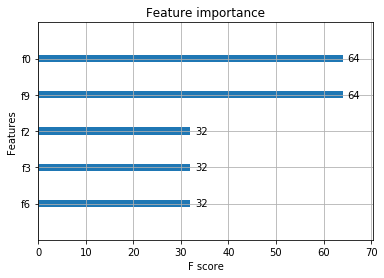

In [20]:
xgbc=xgb.XGBClassifier(max_septh=4, n_estimators=32, learning_rate=0.01)
xgbc.fit(X_train, y_train)
plot_importance(xgbc)
pyplot.show()

[0.19298679 0.         0.20362529 0.10415599 0.         0.
 0.03381463 0.         0.         0.46541724]


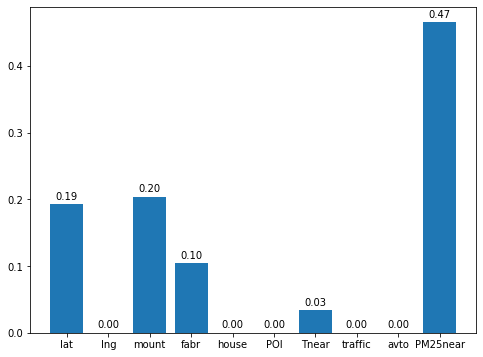

In [22]:
cols2=data_model.columns[:-1]
print(xgbc.feature_importances_)
# plot
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))
pyplot.bar(cols2, xgbc.feature_importances_)
for x,y in zip(cols2, xgbc.feature_importances_):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') 
file_name='feature_sel.jpg'
plt.savefig(file_name,format='jpg',dpi=600)
pyplot.show()


In [23]:
# Set the parameters by cross-validation
tuned_parameters = {'hidden_layer_sizes': [(32,), (64,), (32, 64, 32)],
                    'activation': ['tanh', 'relu'],
                    'solver': ['lbfgs', 'adam', 'sgd']}

clf4 = GridSearchCV(MLPClassifier(random_state=1, batch_size=4, early_stopping=True), 
                    tuned_parameters,
                    n_jobs=6,
                    scoring='accuracy',
                    cv=5)

clf4.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf4.best_score_, clf4.best_params_))
print()

Best score, and parameters, found on development set:

0.620 for {'activation': 'relu', 'hidden_layer_sizes': (32,), 'solver': 'lbfgs'}



### 2. Models testing

In [24]:
print()
print(53 * '=')
print(15 * ' ' + 'SUPPORT VECTOR MACHINE')
print(53 * '-')
print(classification_report(y_test, clf1.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')
print(53 * '=')
print(20 * ' ' + 'RANDOM FOREST')
print(53 * '-')
print(classification_report(y_test, clf2.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')
print(53 * '=')
print(14 * ' ' + 'EXTREME GRADIENT BOOSTING')
print(53 * '-')
print(classification_report(y_test, clf3.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')
print(53 * '=')
print(15 * ' ' + 'MULTI-LAYER PERCEPTRON')
print(53 * '-')
print(classification_report(y_test, clf4.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')


               SUPPORT VECTOR MACHINE
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       0.43      0.75      0.55         4
           3       1.00      0.75      0.86         8

    accuracy                           0.69        16
   macro avg       0.70      0.67      0.66        16
weighted avg       0.77      0.69      0.71        16

-----------------------------------------------------
                    RANDOM FOREST
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       0.60      0.75      0.67         4
           3       0.88      0.88      0.88         8

    accuracy                           0.75        16
   macro avg       0.71      0.71      0.70        16
weighted avg       0.75      0.75      0.75        16

---

# *********** Only chossen data ********************
### 1. Training

In [25]:
data_model2=data_model[["lat", "mount", "fabr","Tnear", "PM25near", "Class"]]

In [26]:
# Divide data in train and testing
train_split, test_split = train_test_split(data_model2, test_size=0.4, random_state=1, stratify=data['Class'])
X_train = train_split.iloc[:, :-1].values
y_train = train_split.iloc[:, -1].values
X_test = test_split.iloc[:, :-1].values
y_test = test_split.iloc[:, -1].values

In [27]:
# Standardize train/test datasets (use same coeff.)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [28]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]

clf1 = GridSearchCV(SVC(random_state=1),
                    tuned_parameters,
                    n_jobs=6,
                    scoring='accuracy',
                    cv=5)
clf1.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf1.best_score_, clf1.best_params_))
print()

Best score, and parameters, found on development set:

0.760 for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}



In [29]:
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [8, 32, 64, 128],
                    'max_features': ['auto', 'sqrt'],
                    'max_depth': [4, 5, 6, 7, 8],
                    'criterion': ['gini', 'entropy']}

clf2 = GridSearchCV(RandomForestClassifier(random_state=1),
                    tuned_parameters,
                    n_jobs=6,
                    scoring='accuracy',
                    cv=5)
clf2.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf2.best_score_, clf2.best_params_))
print()

Best score, and parameters, found on development set:

0.710 for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 32}



In [30]:
# Set the parameters by cross-validation
tuned_parameters = {'learning_rate': [0.01, 0.001],
              'max_depth': [4, 5, 6, 7, 8],
              'n_estimators': [32, 256, 512, 1024]}

clf3 = GridSearchCV(xgb.XGBClassifier(random_state=1),
                   tuned_parameters,
                   n_jobs=-1,
                   scoring='accuracy', 
                   cv=5)
clf3.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf3.best_score_, clf3.best_params_))
print()

Best score, and parameters, found on development set:

0.740 for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 32}



In [31]:
# Set the parameters by cross-validation
tuned_parameters = {'hidden_layer_sizes': [(32,), (64,), (32, 64, 32)],
                    'activation': ['tanh', 'relu'],
                    'solver': ['lbfgs', 'adam']}

clf4 = GridSearchCV(MLPClassifier(random_state=1, batch_size=4, early_stopping=True), 
                    tuned_parameters,
                    n_jobs=6,
                    scoring='accuracy',
                    cv=5)

clf4.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf4.best_score_, clf4.best_params_))
print()

Best score, and parameters, found on development set:

0.760 for {'activation': 'relu', 'hidden_layer_sizes': (32,), 'solver': 'lbfgs'}



In [32]:
print()
print(53 * '=')
print(15 * ' ' + 'SUPPORT VECTOR MACHINE')
print(53 * '-')
print(classification_report(y_test, clf1.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')
print(53 * '=')
print(20 * ' ' + 'RANDOM FOREST')
print(53 * '-')
print(classification_report(y_test, clf2.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')
print(53 * '=')
print(14 * ' ' + 'EXTREME GRADIENT BOOSTING')
print(53 * '-')
print(classification_report(y_test, clf3.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')
print(53 * '=')
print(15 * ' ' + 'MULTI-LAYER PERCEPTRON')
print(53 * '-')
print(classification_report(y_test, clf4.predict(X_test), target_names=['1', '2', '3']))
print(53 * '-')


               SUPPORT VECTOR MACHINE
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.75      0.75      0.75         4
           2       0.60      0.75      0.67         4
           3       1.00      0.88      0.93         8

    accuracy                           0.81        16
   macro avg       0.78      0.79      0.78        16
weighted avg       0.84      0.81      0.82        16

-----------------------------------------------------
                    RANDOM FOREST
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.50      0.25      0.33         4
           2       0.43      0.75      0.55         4
           3       1.00      0.88      0.93         8

    accuracy                           0.69        16
   macro avg       0.64      0.62      0.60        16
weighted avg       0.73      0.69      0.69        16

---

# **** PREDICTION****

In [33]:
data_pred=pd.read_csv("pred.csv", sep=";")
data_pred.head()

,adress,lat,lng,mount,fabr,Tnear
0,elya,43.199860,76.887912,4.64,7.8,17.4
1,elvira,43.255685,76.945128,5.34,4.3,5.6
2,amina,43.228600,76.904000,5.60,2.9,9.2


In [34]:
#Adding new feature - PM2.5 of the another sensor with the most similar characteristics

data_for_corr=data[["lat", "lng", "mount", "fabr", "Tnear"]]
data_pred=data_pred.drop(["adress"], axis=1)
data_for_corr=data_for_corr.append(data_pred, ignore_index=True)

cols=data_for_corr.columns
data_corrT=data_for_corr.T.corr()
data_corrT[data_corrT==1.0] = 0
data_corrT["max"]=data_corrT.idxmax()
data_corrT.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,max
0,0.000000,0.988911,0.995948,0.995515,0.999120,0.991408,0.997927,0.997652,0.980255,0.996332,...,0.999746,0.966369,0.982067,0.992197,0.999427,0.999264,0.974866,0.997019,0.992869,34
1,0.988911,0.000000,0.997945,0.997934,0.991523,0.999737,0.985640,0.993747,0.993724,0.996992,...,0.987929,0.991886,0.998237,0.998556,0.988300,0.993319,0.993052,0.996524,0.995091,20
2,0.995948,0.997945,0.000000,0.998924,0.996549,0.998697,0.994353,0.998703,0.992090,0.998604,...,0.995042,0.983273,0.993443,0.997748,0.995256,0.997962,0.986736,0.998652,0.995412,23
3,0.995515,0.997934,0.998924,0.000000,0.997661,0.998984,0.990976,0.996253,0.988297,0.999907,...,0.995227,0.985401,0.995259,0.999432,0.995239,0.998354,0.990474,0.999804,0.998472,9
4,0.999120,0.991523,0.996549,0.997661,0.000000,0.993981,0.994709,0.996222,0.979583,0.998433,...,0.999424,0.973495,0.987092,0.995569,0.999277,0.999770,0.982092,0.998786,0.996830,12


In [35]:
data_pred_max_id=np.array(data_corrT.iloc[-3:,-1])
data_pred["PM25near"]=0
for i in range(len(data_pred)):
    data_pred.iloc[i,-1]=data.iloc[data_pred_max_id[i],12]
data_pred.head()

,lat,lng,mount,fabr,Tnear,PM25near
0,43.199860,76.887912,4.64,7.8,17.4,22.995455
1,43.255685,76.945128,5.34,4.3,5.6,68.388934
2,43.228600,76.904000,5.60,2.9,9.2,27.810385


In [36]:
X_pred=np.array(data_pred[["lat", "mount", "fabr", "Tnear", "PM25near"]])
data_pred2=data_pred
data_pred2["Class"]=clf3.predict(X_pred)
data_pred2.head()

,lat,lng,mount,fabr,Tnear,PM25near,Class
0,43.199860,76.887912,4.64,7.8,17.4,22.995455,3
1,43.255685,76.945128,5.34,4.3,5.6,68.388934,3
2,43.228600,76.904000,5.60,2.9,9.2,27.810385,3


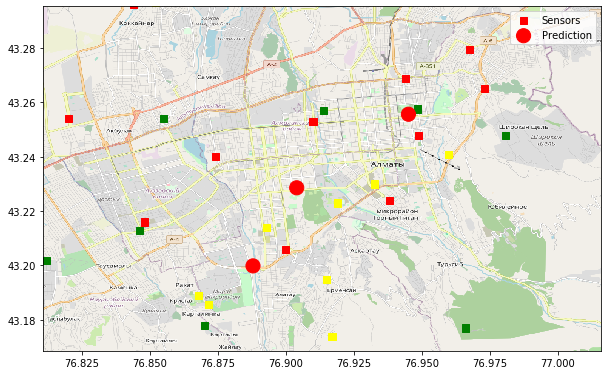

In [37]:
BBox = ((76.8105,   77.0159,      
         43.1686, 43.2954))
ruh_m = plt.imread('map.png')
fig, ax = plt.subplots(figsize = (10,10))
colors = {1:'green', 2:'yellow', 3:'red'}
class_=data.Class
ax.scatter(data.lng, data.lat, zorder=1, alpha= 1, c=data.Class.map(colors), s=50, marker="s", label="Sensors")
ax.scatter(data_pred2.lng, data_pred2.lat, zorder=1, alpha= 1, c=data_pred2.Class.map(colors), s=200, marker="o", label="Prediction")
#ax.set_title('Sensors in Almaty, Kazakhstan')
#ax.set_xlim(BBox[0],BBox[1])
#ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
ax.legend()
file_name='sensor_map.jpg'
plt.savefig(file_name,format='jpg',dpi=600)

# Additional
## ANN constracting

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
encoded_Y = encoder.transform(y_test)
test_dummy_y=np_utils.to_categorical(encoded_Y)

In [ ]:
model = Sequential()
model.add(Dense(4, input_dim=5, activation='relu'))
model.add(Dense(3, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history=model.fit(X_train, dummy_y, batch_size = 10, epochs = 250, validation_split=0.25)

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.2, 1)
plt.legend()

plt.show()

# test
test_loss, test_acc = model.evaluate(X_test, test_dummy_y, verbose=2)

## NEW DATA 

### 1. Importing data

In [ ]:
data2=pd.read_csv("project2.csv", sep=";")

In [ ]:
data2.columns

### 2. Data preporation

In [ ]:
data2["PM25near"]=0
temp=pd.DataFrame()
date1=data2["Unnamed: 0"].unique()
for d in date1:
    temp=data2[data2["Unnamed: 0"]==d]
    temp2=temp[["lat","lng","mount", "fabr", "house", "POI", 'PM25','T1', 'T2', 'T3', 'Tnear', 'traffic', "avto"]]
    data_corrT=temp2.T.corr()
    data_corrT[data_corrT==1.0] = 0
    data_corrT["max"]=data_corrT.idxmax()
    for i in range(len(data_corrT)):
        data2.iloc[data_corrT.index[i],-1]=data2.iloc[data_corrT.iloc[i,-1],5]

In [ ]:
data2=data2.drop("wind",1)
data2=data2.drop("Unnamed: 0",1)

In [ ]:
cols=data2.columns
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15,10))
data_cor= sns.heatmap(data2[cols].corr(),
                 cbar=True,
                 annot=True)

In [ ]:
data2.columns

In [ ]:
data_for_model=data2[["month", "year", "temperature", 'preasure', 'oblac', 'prec', 'wind', 'wind speed', 'temp_evening',
       'preasure_ev', 'obl_evening', 'lat', 'lng', 'mount', 'fabr', 'house', 'POI', 'T1', 'T2', 'T3', 'Tnear',
       'traffic', 'avto', 'PM25near', "pm"]]

In [ ]:
months=data_for_model.month.unique()
for i in range(len(months)):
    data_for_model.loc[data_for_model["month"]==months[i], "month"]=i+1

In [ ]:
#Adding new column CLASS
data_for_model["Class"]=0

for i in range(len(data2)):
    if data_for_model.iloc[i,-2]<26:
        data_for_model.iloc[i,-1]=1
    elif (data_for_model.iloc[i,-2]>26)&(data_for_model.iloc[i,-2]<40):
        data_for_model.iloc[i,-1]=2
    elif (data_for_model.iloc[i,-2]>40)&(data_for_model.iloc[i,-2]<66):
        data_for_model.iloc[i,-1]=3
    elif (data_for_model.iloc[i,-2]>66)&(data_for_model.iloc[i,-2]<92):
        data_for_model.iloc[i,-1]=4
    else:
        data_for_model.iloc[i,-1]=5
data_for_model.Class.value_counts()

In [ ]:
#data_for_model=data_for_model.drop("pm", 1)
data_for_model=data_for_model.drop("wind", 1)

In [ ]:
data_for_model=data_for_model[data_for_model["year"]!==2017]
data_for_model=data_for_model[data_for_model["oblac"]!="#Н/Д"]

In [ ]:
data_for_model.loc[data_for_model["prec"]=="гроза", "prec"]=1

### 3. Training

In [ ]:
# Divide data in train and testing
train_split, test_split = train_test_split(data_for_model, test_size=0.4, random_state=1, stratify=data_for_model['Class'])
X_train = train_split.iloc[:, :-1].values
y_train = train_split.iloc[:, -1].values
X_test = test_split.iloc[:, :-1].values
y_test = test_split.iloc[:, -1].values

In [ ]:
# Standardize train/test datasets (use same coeff.)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = {'learning_rate': [0.01, 0.001],
              'max_depth': [4, 5, 6, 7, 8],
              'n_estimators': [32, 256, 512, 1024]}

clf3 = GridSearchCV(xgb.XGBClassifier(random_state=1),
                   tuned_parameters,
                   n_jobs=-1,
                   scoring='precision_weighted', 
                   cv=5)
clf3.fit(X_train, y_train)

print('Best score, and parameters, found on development set:')
print()
print('%0.3f for %r' % (clf3.best_score_, clf3.best_params_))
print()

In [ ]:
xgbc=xgb.XGBClassifier(max_septh=4, n_estimators=32, learning_rate=0.01)
xgbc.fit(X_train, y_train)
plot_importance(xgbc)
pyplot.show()

In [ ]:
print(classification_report(y_test, xgbc.predict(X_test), target_names=['1', '2', '3', "4", "5"]))
print(53 * '-')

In [ ]:
print(xgbc.feature_importances_)
# plot
pyplot.bar(range(len(xgbc.feature_importances_)), xgbc.feature_importances_)
pyplot.show()

In [ ]:
data_for_model.columns